In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib notebook
sns.set()

## Time it all

In [71]:
import galsim
from mdetsims import Sim
from mdetsims.metacal import MetacalPlusMOF, METACAL_TYPES
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG

In [87]:
# %%time

for i in range(2):
    rng = np.random.RandomState(seed=100)
    des_sim = Sim(
        rng=rng,
        g1=0.02 - i*0.04,
        gal_type='exp',
        scale=0.263,
        psf_type='gauss',
        n_coadd=30,
        n_coadd_psf=1,
        gal_grid=7)

    mbobs = des_sim.get_mbobs()
    mm = MetacalPlusMOF(TEST_METACAL_MOF_CONFIG, mbobs, rng)
    mm.go()

## Look at the Parts

In [2]:
import galsim
from mdetsims import Sim

In [74]:
des_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='exp',
    scale=0.263,
    psf_type='gauss',
    n_coadd=30,
    n_coadd_psf=1,
    gal_grid=7,
    gal_kws={'survey_name': 'DES'})

In [75]:
%%time

mbobs = des_sim.get_mbobs()

CPU times: user 187 ms, sys: 3.23 ms, total: 190 ms
Wall time: 190 ms


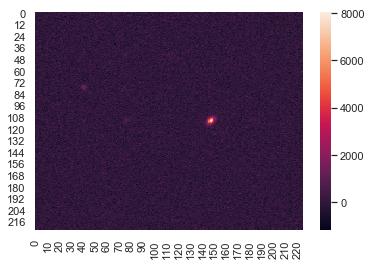

In [67]:
plt.figure()
sns.heatmap(mbobs[0][0].image)

## Run it all at once

In [68]:
from mdetsims.metacal import MetacalPlusMOF, METACAL_TYPES
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG

In [91]:
%%time

rng = np.random.RandomState(seed=100)
mm = MetacalPlusMOF(TEST_METACAL_MOF_CONFIG, mbobs, rng)
mm.go()

CPU times: user 9 s, sys: 1.24 s, total: 10.2 s
Wall time: 10.3 s


In [92]:
res = mm.result

In [93]:
def _mask(cat, s2n_cut, size_cut):
    return (cat['mcal_s2n'] > s2n_cut) & (cat['mcal_T_ratio'] > size_cut)

msks = {}
for sh in METACAL_TYPES:
    msks[sh] = _mask(res[sh], 10, 0.5)

In [94]:
g1_1p = np.mean(res['1p']['mcal_g'][msks['noshear'], 0])
g1_1m = np.mean(res['1m']['mcal_g'][msks['noshear'], 0])
R11 = (g1_1p - g1_1m) / 2 / 0.01

g2_2p = np.mean(res['2p']['mcal_g'][msks['noshear'], 1])
g2_2m = np.mean(res['2m']['mcal_g'][msks['noshear'], 1])
R22 = (g2_2p - g2_2m) / 2 / 0.01

g1_1p = np.mean(res['noshear']['mcal_g'][msks['1p'], 0])
g1_1m = np.mean(res['noshear']['mcal_g'][msks['1m'], 0])
R11_sel = (g1_1p - g1_1m) / 2 / 0.01

g2_2p = np.mean(res['noshear']['mcal_g'][msks['2p'], 1])
g2_2m = np.mean(res['noshear']['mcal_g'][msks['2m'], 1])
R22_sel = (g2_2p - g2_2m) / 2 / 0.01

R11 += R11_sel
R22 += R22_sel

In [63]:
R11, R22

(0.6041811227637205, 0.8294483640960332)

In [64]:
g1_1p = np.mean(res['1p']['mcal_g'][msks['1p'], 0])
g1_1m = np.mean(res['1m']['mcal_g'][msks['1m'], 0])
R11 = (g1_1p - g1_1m) / 2 / 0.01

g2_2p = np.mean(res['2p']['mcal_g'][msks['2p'], 1])
g2_2m = np.mean(res['2m']['mcal_g'][msks['2m'], 1])
R22 = (g2_2p - g2_2m) / 2 / 0.01

R11, R22

(0.6041811227637205, 0.8294483640960332)

## Run Detection

In [ ]:
from metadetect.detect import MEDSifier
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG
from mdetsims.metacal import get_fofs, MOFFitter, MetacalFitter
from mdetsims.metacal.util import get_masked_frac

mfier = MEDSifier(
    mbobs=mbobs,
    sx_config=TEST_METACAL_MOF_CONFIG['sx'],
    meds_config=TEST_METACAL_MOF_CONFIG['meds'])

In [ ]:
mbmeds = mfier.get_multiband_meds()

## Try the FoFs

In [ ]:
res = get_fofs(mfier.cat, TEST_METACAL_MOF_CONFIG['fofs'])

In [ ]:
n_fofs = np.max(res[1]['fofid'])

In [ ]:
for fofid in range(n_fofs):
    msk = res[1]['fofid'] == fofid
    if np.sum(msk) > 2:
        inds = res[1]['number'][msk] - 1
        list_of_mbobs = []
        for ind in inds:
            o = mbmeds.get_mbobs(ind)
            o[0].meta['Tsky'] = 1
            o.meta['masked_frac'] = get_masked_frac(o)
            o[0].meta['magzp_ref'] = 26.5
            o.meta['id'] = ind + 1
            o.meta['fofid'] = fofid
            list_of_mbobs.append(o)

In [ ]:
list_of_mbobs[0].meta

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(np.arcsinh(list_of_mbobs[0][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(np.arcsinh(list_of_mbobs[1][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(np.arcsinh(list_of_mbobs[2][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(np.arcsinh(list_of_mbobs[3][0][0].image), square=True, ax=ax)

## Try MOF

In [ ]:
fitter = MOFFitter(TEST_METACAL_MOF_CONFIG, 1, np.random.RandomState(seed=10))

In [ ]:
od, ed = fitter.go(list_of_mbobs)

In [ ]:
od.shape

In [ ]:
mof_fitter = fitter.get_mof_fitter()

In [ ]:
rs = mof_fitter.make_corrected_obs()

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(np.arcsinh(rs[0][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(np.arcsinh(rs[1][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(np.arcsinh(rs[2][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(np.arcsinh(rs[3][0][0].image), square=True, ax=ax)

## Try Metacal + MOF

In [ ]:
rng = np.random.RandomState(seed=10)
nband = 1
mcal = MetacalFitter(
    TEST_METACAL_MOF_CONFIG, nband, rng, 
    mof_fitter=MOFFitter(TEST_METACAL_MOF_CONFIG, nband, rng))

In [ ]:
mcal.go(list_of_mbobs)

In [ ]:
res = mcal.result

In [ ]:
R11 = (res['mcal_g_1p'][:, 0] - res['mcal_g_1m'][:, 0]) / 2 / 0.01
R22 = (res['mcal_g_2p'][:, 1] - res['mcal_g_2m'][:, 1]) / 2 / 0.01

In [ ]:
R11, R22

In [ ]:
res['id']